<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lg%ED%99%94%ED%95%99_%ED%86%B5%ED%95%A9%ED%85%8C%EC%9D%B4%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘 시작

## 라이브러리 설치

In [1]:
!pip install finance-datareader
!pip install pykrx
!pip install pymysql
!pip install konlpy
from konlpy.tag import Okt
okt = Okt()

     |████████████████████████████████| 70 kB 3.7 MB/s 
     |████████████████████████████████| 60 kB 6.2 MB/s 
     |████████████████████████████████| 251 kB 16.8 MB/s 
     |████████████████████████████████| 43 kB 1.2 MB/s 
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 448 kB 50.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## 패키지 & 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

In [4]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min())) + org_x_np.min()

## 통합테이블 생성

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# total_table = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/total_table.csv') # 기존 테이블

In [7]:
# 구성
dic = {'code' : [],
       'date' : [],
       'lstm' : [],
       'arima' : [],
       'fbprophet' : [],
       'RL' : [],
    #    'mail_news' : [],
    #    'mail_news_nsi' : [],
    #    'asia_news' : [],
    #    'asia_news_nsi': [],
    #    'youtube_sam' : [],
    #    'youtube_su' : [],
    #    'youtube_han' : [],
       'close' : []}

total_table = pd.DataFrame(dic)

In [8]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'close'], dtype='object')

In [9]:
total_table

,code,date,lstm,arima,fbprophet,RL,close


## LSTM 예측결과

### 사용 데이터 로드 및 전처리

In [10]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
lstm = money_sur('051910', '2018', end_date)

In [11]:
lstm = lstm.set_index('Date')

In [12]:
lstm.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,407000,415000,406500,411000,153739,0.014815,188597,23.60,2.18,17417,1.22,5000
2018-01-03,404000,413000,404000,409500,103370,-0.003650,188597,23.51,2.17,17417,1.22,5000
2018-01-04,410000,412000,395000,395500,215698,-0.034188,188597,22.71,2.10,17417,1.26,5000
2018-01-05,396500,405500,395000,405000,154954,0.024020,188597,23.25,2.15,17417,1.23,5000
2018-01-08,409000,425000,407000,424500,321484,0.048148,188597,24.37,2.25,17417,1.18,5000


In [13]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
lstm_sc = sc.fit_transform(lstm)

In [14]:
scale_cols = lstm.columns
lstm_sc_df = pd.DataFrame(lstm_sc, columns=[scale_cols], index=lstm.index)

In [15]:
lstm_sc_df.head()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
Date,,,,,,,,,,,,
2018-01-02,0.208820,0.182754,0.227742,0.226817,0.027212,0.532225,0.0,0.048523,0.307065,0.626445,0.425620,0.375
2018-01-03,0.204929,0.180180,0.224516,0.224937,0.012156,0.481409,0.0,0.048148,0.304348,0.626445,0.425620,0.375
2018-01-04,0.212711,0.178893,0.212903,0.207393,0.045732,0.397363,0.0,0.044810,0.285326,0.626445,0.442149,0.375
2018-01-05,0.195201,0.170528,0.212903,0.219298,0.027575,0.557560,0.0,0.047063,0.298913,0.626445,0.429752,0.375
2018-01-08,0.211414,0.195624,0.228387,0.243734,0.077353,0.623963,0.0,0.051736,0.326087,0.626445,0.409091,0.375


In [16]:
for i in scale_cols:
  for s in range(1, 11):  
    lstm_sc_df[(i+'shift_{}'.format(s),)] = lstm_sc_df[(i,)].shift(s)

In [17]:
lstm_sc_df.dropna()

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,...,PBRshift_1,PBRshift_2,PBRshift_3,PBRshift_4,PBRshift_5,PBRshift_6,PBRshift_7,PBRshift_8,PBRshift_9,PBRshift_10,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-16,0.249027,0.215573,0.256774,0.252506,0.024505,0.456815,0.0,0.053405,0.336957,0.626445,0.400826,0.375,0.233463,0.223735,0.227626,0.235409,0.235409,0.211414,0.195201,0.212711,0.204929,0.208820,0.216860,0.200772,0.196911,0.200129,0.210425,0.195624,0.170528,0.178893,0.180180,0.182754,0.252258,0.243226,0.239355,0.240645,0.250323,0.228387,0.212903,0.212903,...,0.345109,0.328804,0.320652,0.315217,0.328804,0.326087,0.298913,0.285326,0.304348,0.307065,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.392562,0.404959,0.413223,0.417355,0.409091,0.409091,0.429752,0.442149,0.425620,0.425620,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375
2018-01-17,0.239300,0.208494,0.245806,0.238722,0.034528,0.421294,0.0,0.050776,0.320652,0.626445,0.413223,0.375,0.249027,0.233463,0.223735,0.227626,0.235409,0.235409,0.211414,0.195201,0.212711,0.204929,0.215573,0.216860,0.200772,0.196911,0.200129,0.210425,0.195624,0.170528,0.178893,0.180180,0.256774,0.252258,0.243226,0.239355,0.240645,0.250323,0.228387,0.212903,...,0.336957,0.345109,0.328804,0.320652,0.315217,0.328804,0.326087,0.298913,0.285326,0.304348,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.400826,0.392562,0.404959,0.413223,0.417355,0.409091,0.409091,0.429752,0.442149,0.425620,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375
2018-01-18,0.226329,0.193694,0.239355,0.234336,0.029627,0.468546,0.0,0.049942,0.315217,0.626445,0.417355,0.375,0.239300,0.249027,0.233463,0.223735,0.227626,0.235409,0.235409,0.211414,0.195201,0.212711,0.208494,0.215573,0.216860,0.200772,0.196911,0.200129,0.210425,0.195624,0.170528,0.178893,0.245806,0.256774,0.252258,0.243226,0.239355,0.240645,0.250323,0.228387,...,0.320652,0.336957,0.345109,0.328804,0.320652,0.315217,0.328804,0.326087,0.298913,0.285326,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.413223,0.400826,0.392562,0.404959,0.413223,0.417355,0.409091,0.409091,0.429752,0.442149,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375
2018-01-19,0.221790,0.194981,0.241290,0.242481,0.025215,0.534352,0.0,0.051527,0.326087,0.626445,0.409091,0.375,0.226329,0.239300,0.249027,0.233463,0.223735,0.227626,0.235409,0.235409,0.211414,0.195201,0.193694,0.208494,0.215573,0.216860,0.200772,0.196911,0.200129,0.210425,0.195624,0.170528,0.239355,0.245806,0.256774,0.252258,0.243226,0.239355,0.240645,0.250323,...,0.315217,0.320652,0.336957,0.345109,0.328804,0.320652,0.315217,0.328804,0.326087,0.298913,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.626445,0.417355,0.413223,0.400826,0.392562,0.404959,0.413223,0.417355,0.409091,0.409091,0.429752,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375
2018-01-22,0.232815,0.196911,0.234839,0.235589,0.042098,0.455711,0.0,0.050192,0.317935,0.626445,0.417355,0.375,0.221790,0.226329,0.239300,0.249027,0.233463,0.223735,0.227626,0.235409,0.235409,0.211414,0.194981,0.193694,0.208494,0.215573,0.216860,0.200772,0.196911,0.200129,0.210425,0.19562

In [18]:
X_test = lstm_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = lstm_sc_df.dropna()[['Close']]

X_test= X_test.values
y_test = y_test.values

In [19]:
X_test

array([[0.23346304, 0.22373541, 0.22762646, ..., 0.375     , 0.375     ,
        0.375     ],
       [0.24902724, 0.23346304, 0.22373541, ..., 0.375     , 0.375     ,
        0.375     ],
       [0.23929961, 0.24902724, 0.23346304, ..., 0.375     , 0.375     ,
        0.375     ],
       ...,
       [0.6692607 , 0.68871595, 0.67055772, ..., 1.        , 1.        ,
        1.        ],
       [0.65888457, 0.6692607 , 0.68871595, ..., 1.        , 1.        ,
        1.        ],
       [0.69001297, 0.65888457, 0.6692607 , ..., 1.        , 1.        ,
        1.        ]])

In [20]:
X_test_t = X_test.reshape(X_test.shape[0], 10, 12)

### 모델 로드

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda,Dropout,Flatten
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(LSTM(64,
               input_shape = (10, 12),
               return_sequences= True))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'tanh'))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1))



lstm_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/LSTM/'
lg_lstm = 'lstm_lg.h5'

model.load_weights(lstm_path+lg_lstm)

### 모델 결과

In [22]:
pred = model.predict(X_test_t)

In [23]:
pred.shape, y_test.shape

((915, 1), (915, 1))

In [24]:
pred_act = reverse_min_max_scaling(lstm['Close'], pred)

In [25]:
pred_act.shape

(915, 1)

In [26]:
total_table['date'] = lstm.index[10:]
total_table['lstm'] = pred_act[:]
total_table['close'] = lstm.Close[10:].values.reshape(-1,1)
total_table['code'] = '051910'
total_table['change'] = lstm.Change[10:].values.reshape(-1,1)

In [27]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,051910,2018-01-16,366856.129855,NaN,NaN,NaN,431500,-0.012586
1,051910,2018-01-17,369755.234092,NaN,NaN,NaN,420500,-0.025492
2,051910,2018-01-18,374660.062224,NaN,NaN,NaN,417000,-0.008323
3,051910,2018-01-19,374598.989397,NaN,NaN,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,NaN,NaN,NaN,418000,-0.012987
...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,NaN,NaN,NaN,776000,0.007792
911,051910,2021-09-29,762308.091164,NaN,NaN,NaN,767000,-0.011598
912,051910,2021-09-30,766450.246215,NaN,NaN,NaN,776000,0.011734
913,051910,2021-10-01,769267.016292,NaN,NaN,NaN,770000,-0.007732


## arima 예측결과

In [28]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('051910', '2015', end_date)

In [29]:
df = samsung_df[['Date','Close']]
df.columns = ['Date', 'Price']

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# 학습, 테스트 데이터 분리
for ru in range(-len(total_table),0):
    rus = ru+1
    train = df[:ru]
    test = df[ru:]

    model = ARIMA(train.Price.values, order = (2,2,0))
    model_fit = model.fit(trend = 'nc', full_output = True, disp = True)

    fore = model_fit.forecast(steps=1) # 오늘 예측

    # 오늘 예측 데이터
    pred_arima_y = fore[0].tolist()

    # 실제 오늘 데이터 
    test_y = test.Price.values

    # # 신뢰구간
    # # 예측 데이터 최소값
    # pred_y_lower = []
    # # 예측 데이터 최대값
    # pred_y_upper = []

    # for lower_upper in fore[2]:
    #     lower = lower_upper[0]
    #     upper = lower_upper[1]
    #     pred_y_lower.append(lower)
    #     pred_y_upper.append(upper)
    if rus == 0:
        total_table['arima'].iloc[ru:] = pred_arima_y
    else:
        total_table['arima'].iloc[ru:rus] = pred_arima_y

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                 1659
Model:                 ARIMA(2, 2, 0)   Log Likelihood              -18114.839
Method:                       css-mle   S.D. of innovations          13359.945
Date:                Tue, 05 Oct 2021   AIC                          36235.679
Time:                        01:59:04   BIC                          36251.921
Sample:                             2   HQIC                         36241.699
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D2.y    -0.6961      0.023    -30.457      0.000      -0.741      -0.651
ar.L2.D2.y    -0.3644      0.023    -15.947      0.000      -0.409      -0.320
                                    Roots           

In [31]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,051910,2018-01-16,366856.129855,443937.583211,NaN,NaN,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,NaN,NaN,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,NaN,NaN,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,NaN,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,NaN,NaN,418000,-0.012987
...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,NaN,NaN,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,NaN,NaN,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,NaN,NaN,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,NaN,NaN,770000,-0.007732


## fbprophet 예측

In [32]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
samsung_df = money_sur('051910', start = '2018', end = end_date)
df1 = samsung_df[['Date','Close']]
df1.columns = ['ds', 'y']

from fbprophet import Prophet

prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.6)

prophet.fit(df1)

# 10일단위로 예측값을 가져옴
future_data = prophet.make_future_dataframe(periods = 10, freq = 'd')
forecast_data = prophet.predict(future_data)

In [33]:
total_table['fbprophet'] = forecast_data[forecast_data['ds'].isin(list(total_table.date.values))]['yhat'].values

In [34]:
total_table

,code,date,lstm,arima,fbprophet,RL,close,change
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,NaN,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,NaN,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,NaN,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,NaN,418000,-0.012987
...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,NaN,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,NaN,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,NaN,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,NaN,770000,-0.007732


In [35]:
# total_table.to_csv('./total_table.csv', index =False)

## RL 결과

### 데이터 로딩 및 함수 로딩

In [36]:
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

# 금융정보 조회하기
def dataset_loaderKR(stock_name, start, end, train_ratio=0.8):
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')
    date_split = data.index[int(train_ratio*len(data))] 

    return data[:date_split], data[date_split:], date_split


# ENV 설정
class Environment1:
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs

    def step(self, act):
        reward = 0
        
        # action
        # 0: Idle
        # 1: 매수
        # 2: 매도
        if act == 1: #매수
            self.positions.append(self.data.iloc[self.t, :]['Close'])
        elif act == 2: # 매도
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        if (self.t==len(self.data)-1):
            self.done=True
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

# MODEL
class Q_Network(nn.Module):
    def __init__(self,obs_len,hidden_size,actions_n):
        super(Q_Network,self).__init__()
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
    def forward(self,x):
        h = self.fc_val(x)
        return (h)

In [37]:
(train, test, date_split) = dataset_loaderKR('051910', start = '2000', end = end_date)

### 모델 로딩 및 결과

In [38]:
rl_path = '/content/drive/My Drive/Final PJT - 업빛투/Regression/RL/LG화학_결과/'
lg_rl = 'lg_rl_재무정보.h5'

In [39]:
# 모델 로딩
model = torch.load(rl_path+lg_rl)

test_env = Environment1(test)
pobs = test_env.reset()
test_acts = []
test_rewards = []

for _ in range(len(test_env.data)-1):
    pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    test_acts.append(pact.item())
            
    obs, reward, done = test_env.step(pact.numpy())
    test_rewards.append(reward)

    pobs = obs

# sell remaining stocks
profits = 0
for p in test_env.positions:
	profits += (test_env.data.iloc[test_env.t, :]['Close'] - p)

test_env.profits += profits
test_env.positions = []

test_profits = test_env.profits
pact = model(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
pact = np.argmax(pact.data)
next_action = pact.item()
test['Action'] = test_acts + [next_action]


print( )
print( test )
print( )
print("결과")
print( "손익결과 $%.2f" % round(test_profits,2) )
# 0: Idle
# 1: 매수
# 2: 매도


           Date    Open    High     Low  ...    EPS   DIV    DPS  Action
4043 2017-08-22  350000  364000  350000  ...  17417  1.38   5000       0
4044 2017-08-23  365000  366500  362000  ...  17417  1.37   5000       1
4045 2017-08-24  366000  378000  365500  ...  17417  1.33   5000       1
4046 2017-08-25  375000  375000  367000  ...  17417  1.36   5000       2
4047 2017-08-28  368000  372000  365500  ...  17417  1.35   5000       2
...         ...     ...     ...     ...  ...    ...   ...    ...     ...
5049 2021-09-28  777000  783000  765000  ...   6666  1.29  10000       2
5050 2021-09-29  762000  769000  749000  ...   6666  1.30  10000       2
5051 2021-09-30  754000  780000  748000  ...   6666  1.29  10000       1
5052 2021-10-01  778000  781000  764000  ...   6666  1.30  10000       2
5053 2021-10-05  767000  769000  739000  ...   6666  1.35  10000       2

[1011 rows x 14 columns]

결과
손익결과 $37000.00


In [40]:
test['Action'] = np.where(test['Action'] == 1,1,
                          np.where(test['Action'] == 2,-1,0))

In [41]:
test['Action'][-10:]

5044    0
5045   -1
5046   -1
5047   -1
5048   -1
5049   -1
5050   -1
5051    1
5052   -1
5053   -1
Name: Action, dtype: int64

In [42]:
total_table['RL'] = test[test['Date'].isin(list(total_table.date.values))]['Action'].values

In [43]:
total_table[-10:]

,code,date,lstm,arima,fbprophet,RL,close,change
905,051910,2021-09-16,764660.679221,711414.149652,755779.645171,0,716000,-0.002786
906,051910,2021-09-17,759266.436100,705394.366454,756408.679557,-1,701000,-0.020950
907,051910,2021-09-23,753433.600664,689876.360292,753227.688787,-1,760000,0.084165
908,051910,2021-09-24,749505.295634,772342.223429,753003.685871,-1,761000,0.001316
909,051910,2021-09-27,750926.047444,775314.563748,746793.375838,-1,770000,0.011827
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,770000,-0.007732
914,051910,2021-10-05,775579.920292,767881.439649,735374.456053,-1,745000,-0.032468


## News 긍부정 결과
- '매일경제', '아시아경제'

In [44]:
# corp_list = ['samsung', 'hyundai', 'lg', 'sk', 'celltrion'] 참고용
stock_num_list = ['005930', '005380', '051910', '000660', '068270']
news = ['maeil_news_craw', 'asia_news_craw']
start = (datetime.datetime.now() - datetime.timedelta(20)).strftime("%Y-%m-%d").replace('-','')
end = datetime.datetime.now().strftime("%Y-%m-%d").replace('-', '')

In [45]:
# news_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/Final Data/1. samsung_score.csv') # 연습용

### 관련 함수 및 패키지 로드

In [46]:
import pymysql
import sys
import re

In [47]:
# 블로그에서 가져온 기본적인 한국어 긍부정 텍스트 목록
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/positive_words_self.txt', encoding='utf-8') as pos_blog:
    positive_blog = pos_blog.readlines()
positive_blog = [pos_blog.replace('\n', '') for pos_blog in positive_blog]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/negative_words_self.txt', encoding='utf-8') as neg_blog:
    negative_blog = neg_blog.readlines()
negative_blog = [neg_blog.replace('\n', '') for neg_blog in negative_blog]

# KOSELF 감성 어휘 사전
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_pos.txt', encoding='utf-8') as pos:
    positive = pos.readlines()
positive = [pos.replace('\n', '') for pos in positive]
with open('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/KOSELF_neg.txt', encoding='utf-8') as neg:
    negative = neg.readlines()
negative = [neg.replace('\n', '') for neg in negative]

In [48]:
def news_db(news, stock):
    db = pymysql.connect(
            user='root', 
            passwd='1234', 
            host='3.35.70.166', 
            db='proj', 
            charset = 'utf8'
        )

    cursor = db.cursor(pymysql.cursors.DictCursor)
    news1 = news + '_news_craw'

    
    sql = "select * from {0}_{1} where length(date)=10".format(news1, stock)
    # sql = "select * from {0}_{1} where (length(date)=10) and (date between {2}00 and {3}23)".format(news1, stock, start, end)
    cursor.execute(sql)
    result = cursor.fetchall()

    # DataFrame으로 변경
    df = pd.DataFrame(result)

    db.close()

    df.rename(columns={'date': 'datetime'}, inplace=True)

    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df['date'] = df['datetime'].str[0:4] + '-' + df['datetime'].str[4:6] + '-' + df['datetime'].str[6:8]
    df['date'] = pd.to_datetime(df['date'])

    # 결측치 제거 → 데이터 로드 시 완료했기 때문에 그다지 필요하지 않은 과정
    df = df.dropna()

    # 시간순으로 정렬
    df.sort_values('datetime', inplace=True)
    df.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)

    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
    stopwords = list(pd.read_csv(url, header=None)[0])

    # Stop Words List에 각 매체명 추가
    except_media_list = ['매일경제', '매일', '경제', 'maeil', 'MK', 'mk',
                         '아시아경제', '아시아', 'Asia', 'ASIA', 'asia',
                         '삼프로TV', '삼프로', 'TV',
                         '슈카월드', '슈카', '월드'
                         '한국경제TV', '한국']
    for word in except_media_list:
        stopwords.append(word)
    
    #### 2. Preprocessing
    '''감성 어휘 사전 : negative / positive
       뉴스 데이터 : samsung / hyundai / lg / sk
       주식 데이터 : stock_samsung / stock_hyundai / stock_lg / stock_sk
       공휴일 데이터 : holidays'''
    
    
    ### 1) 뉴스 데이터 날짜 조정
    
    ## 1-1)업로드 시각 컬럼 추가
    df['time'] = df['datetime'].str[-2:]
    
    ## 1-2) 전일 15시 ~ 금일 15시로 날짜 조정
    after_market = ['15', '16', '17', '18', '19', '20', '21', '22', '23']

    for j in range(len(df['time'])):
        if df['time'][j] in after_market:
            df['date'][j] += datetime.timedelta(1)
        else:
            pass
    
    ## 1-3) 텍스트 전처리
    # \n, \t, \r 제거
    df['text'] = df['text'].str.replace('[\n|\t|\r]', '')
    df['text'] = df['text'].str.replace('\[|\]', '')
    df['text'] = df['text'].str.replace('\<.*\>', '')
    df['text'] = df['text'].str.replace('\\', '')
    df['text'] = df['text'].str.replace('이미지', '')


    ### 2) 주말 및 공휴일 제외
    
    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df[df['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df[df['date'].isin(market_closed_list)]['date'].index:
            df['date'][hoil] += datetime.timedelta(1)
    
    ### 3) Tokenization 컬럼 추가
    
    df['Tokenization'] = 0
    rows = df.shape[0]
    for row in range(rows):
        hangeul = re.compile('[^ ㄱ-ㅣ 가-힣]')                                    # 정규 표현식 → 한글 추출 규칙 : 띄어쓰기(1개)를 포함한 한글
        result = hangeul.sub('', df['text'][row])   # 위에 설정한 hangeul 규칙을 text에 적용
        okt = Okt()                                                               # 형태소 추출
        nouns = okt.nouns(df['text'][row])
        nouns = [x for x in nouns if len(x) > 1]                                  # 한 글자 키워드 제거
        nouns = [x for x in nouns if x not in stopwords]                          # 불용어 제거
        
        corpus = " ".join(nouns)                                                  # List를 String으로 변환
        df['Tokenization'][row] = corpus


    # 점수 산출

    df['Positive_Score'] = 0
    df['Negative_Score'] = 0
    df['Ratio'] = 0.1
    df['Pred'] = 0
    df['NSI'] = 0.1
    
    for score in range(len(df)):
        pos_score = 0 ; neg_score = 0
        
        for token in range(len(df['Tokenization'][score].split())):
            if df['Tokenization'][score].split()[token] in positive:
                pos_score += 1
            elif df['Tokenization'][score].split()[token] in negative:
                neg_score += 1
            else:
                pass
        
        df['Positive_Score'][score] = pos_score
        df['Negative_Score'][score] = neg_score
        
        # 긍정과 부정의 비율
        if (pos_score==0) and (neg_score==0):
            df['Ratio'][score] = 0.5   # 둘 다 0일 경우에는 긍정으로 가정
        else:
            df['Ratio'][score] = pos_score / (pos_score + neg_score)
        
        # 예측 결과
        if df['Ratio'][score]>=0.5:
            df['Pred'][score] = 1
        else:
            df['Pred'][score] = -1
        
        # 뉴스심리지수(NSI) 계산
        if (pos_score==0) and (neg_score==0):
            df['NSI'][score] = 101
        else:
            df['NSI'][score] = (pos_score - neg_score) / (pos_score + neg_score) * 100 + 100
    
    return df

### 매일경제

In [49]:
# mail_df = news_df[(news_df['news'] == '매일경제') & (news_df['st_cd'] == 5930)]

In [50]:
mail_df = news_db('maeil', '051910')

In [51]:
mail_df.head()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
0,LG화학,051910,매일경제,2018010118,中정부 전기차 면세 연장에 코스모화학 등 수혜株 주목,http://news.mk.co.kr/newsRead.php?year=2018&no...,중국발 수요 증가에 힘입어 새해 '전기차 랠리'에 대한 기대감이 확산되고 있다. ...,2018-01-02,18,중국 수요 증가 새해 전기차 랠리 대한 대감 확산 거래소 전기차 배터리 핵심 소재 ...,0,1,0.000000,-1,0.000000
1,LG화학,051910,매일경제,2018010204,"[다시 뛰는 재계] 차세대 먹을거리 차곡차곡 ""4차 산업혁명 우리가 주도""",http://news.mk.co.kr/newsRead.php?year=2018&no...,인천국제공항 제2터미널에서 항공기가 떠오르고 있다. 무술년(戊戌年)을 맞이하는 우리...,2018-01-02,04,인천 국제공항 터미널 항공기 무술년 맞이 기업 보호무역 주의 파고 고유 금리 원화 ...,11,3,0.785714,1,157.142857
2,LG화학,051910,매일경제,2018010204,"LG ,마곡사이언스파크 완공 R&D강화",http://news.mk.co.kr/newsRead.php?year=2018&no...,지난해 미국 라스베이거스에서 열린 `CES 2017`에서 LG전자가 올레드 사이니지...,2018-01-02,04,지난해 미국 라스베이거스 레드 사이니 이용 너비 높이 길이 규모 레드 터널 관람객 ...,3,0,1.000000,1,200.000000
3,LG화학,051910,매일경제,2018010210,"[신년사] 박진수 LG화학 부회장 ""사업구조·사업방식·조직문화 바꿔야""",http://news.mk.co.kr/newsRead.php?year=2018&no...,"박진수 LG화학 부회장. 사진 제공 = LG화학 박진수 LG화학 부회장은 ""기존의 ...",2018-01-02,10,박진수 화학 부회장 사진 제공 화학 박진수 화학 부회장 기존 방식 감히 사업 구조 ...,8,0,1.000000,1,200.000000
4,LG화학,051910,매일경제,2018010215,"코스피, 새해 첫 거래일 상승 마감…코스닥 800 고지 돌파",http://news.mk.co.kr/newsRead.php?year=2018&no...,코스피가 2018년 무술년 첫 거래일 상승 마감했다. 코스닥은 1%대 강세를 나타...,2018-01-03,15,코스피 무술년 거래 상승 마감 코스닥 강세 위쪽 거래 코스닥 위쪽 마감 지난 이후 ...,5,3,0.625000,1,125.000000


In [52]:
mail_ratio = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
mail_nsi = mail_df[mail_df['date'].isin(list(total_table.date.values))][['date','NSI']]

In [53]:
mail_ratio = mail_ratio.groupby(['date']).mean().reset_index()
mail_nsi = mail_nsi.groupby(['date']).mean().reset_index()

In [54]:
mail_ratio.columns = ['date', 'mail_news']
mail_nsi.columns = ['date', 'mail_news_nsi']

In [55]:
total_table = pd.merge(total_table, mail_ratio, on='date', how='left')
total_table = pd.merge(total_table, mail_nsi, on='date', how='left')

In [56]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'close', 'change']]

In [57]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,close,change
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,0,0.825000,165.250000,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,0,0.625000,125.000000,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,-1,1.000000,200.000000,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,-1,0.400000,80.000000,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,1,0.293056,58.861111,418000,-0.012987
...,...,...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,0.317460,63.492063,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,0.000000,0.000000,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,0.416667,83.666667,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,0.742690,148.538012,770000,-0.007732


### 아시아

In [58]:
# asia_df = news_df[(news_df['news'] == '아시아경제') & (news_df['st_cd'] == 5930)]

In [59]:
asia_df = news_db('asia', '051910')

In [60]:
asia_df.tail()

,st_n,st_cd,news,datetime,title,url,text,date,time,Tokenization,Positive_Score,Negative_Score,Ratio,Pred,NSI
3525,LG화학,051910,아시아경제,2021100111,"'고객 가치' 다시 강조한 구광모…""재무지표가 사업 목적 돼선 안돼""",https://view.asiae.co.kr/article/2021100110143...,지난달 30일 LG '사장단 워크샵'서 강조고객 접점 - 미래 준비 방점 두고 현장...,2021-10-01,11,지난달 장단 워크샵 강조 고객 접점 미래 준비 방점 현장 경영 행보 구광모 회장 지...,20,3,0.869565,1,173.913043
3526,LG화학,051910,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,21,0.045455,-1,9.090909
3527,LG화학,051910,아시아경제,2021100116,코스피 3000선 위협...코스닥도 천스닥 아래로,https://view.asiae.co.kr/article/2021100116073...,코스피 지수가 미국 증시 부진 여파에 하락 출발한 1일 서울 을지로 하나은행 딜링룸...,2021-10-05,16,코스피 지수 미국 증시 부진 여파 하락 출발 서울 을지로 하나은행 딜링룸 딜러 업무...,1,20,0.047619,-1,9.523810
3528,LG화학,051910,아시아경제,2021100308,"외국인, 한 주 만에 '팔자'…삼전 가장 많이 순매도",https://view.asiae.co.kr/article/2021100220314...,아시아경제 송화정 기자외국인이 국내 증시에서 한 주 만에 매도세로 돌아섰다.3일 한...,2021-10-05,08,송화 기자 외국인 국내 증시 매도 세로 거래소 외국인 지난달 국내 주식시장 매도 외...,4,4,0.500000,1,100.000000
3529,LG화학,051910,아시아경제,2021100309,"외국인·기관, 추석 이후 화학·금융株 쓸어담았다",https://view.asiae.co.kr/article/2021093010064...,썝蹂몃낫湲 븘씠肄아시아경제 박지환 기자 외국인과 기관투자자들이 코스피에서 추석 명절...,2021-10-05,09,몃낫 븘씠 박지환 기자 외국인 기관 투자자 코스피 추석 명절 이후 화학 금융 업종 ...,7,1,0.875000,1,175.000000


In [61]:
asia_ratio = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','Ratio']]
asia_nsi = asia_df[asia_df['date'].isin(list(total_table.date.values))][['date','NSI']]

asia_ratio = asia_ratio.groupby(['date']).mean().reset_index()
asia_nsi = asia_nsi.groupby(['date']).mean().reset_index()

asia_ratio.columns = ['date', 'asia_news']
asia_nsi.columns = ['date', 'asia_news_nsi']

In [62]:
total_table = pd.merge(total_table, asia_ratio, on='date', how='left')
total_table = pd.merge(total_table, asia_nsi, on='date', how='left')

In [63]:
# 컬럼 리셋
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news', 'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change']]

In [64]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,0,0.825000,165.250000,0.583333,117.166667,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,0,0.625000,125.000000,0.233333,46.666667,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,-1,1.000000,200.000000,0.683333,136.666667,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,-1,0.400000,80.000000,NaN,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,1,0.293056,58.861111,0.166667,33.666667,418000,-0.012987
...,...,...,...,...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,0.317460,63.492063,0.181818,36.363636,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,0.000000,0.000000,0.000000,0.000000,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,0.416667,83.666667,0.000000,0.000000,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,0.742690,148.538012,0.634783,126.956522,770000,-0.007732


In [65]:
# total_table.to_csv('total_table.csv', index=False)

## youtube 긍부정 결과
- ['한국경제TV', '슈카월드', '삼프로TV_경제의신과함께']

In [66]:
# # 이전 라벨링 데이터
# youtube_df = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/data/youtube_naver_labeling.csv')

In [67]:
# youtube_df.ch_nm.unique()

### youtube 데이터 전체 로드

In [68]:
def youtube_db():

    com_list = {'하이닉스' : '000660',
            '현대차' : '005380',
            '삼성전자' : '005930',
            'LG화학' : '051910',
            '셀트리온' : '068270'}
    media_list = {'youtube_한국경제_':'hk_',
                'youtube_삼프로_':'sampro_',
                'youtube_슈카_':'suka_'}
    df_list = []
    for n,m in media_list.items():
        for i,j in com_list.items():

            db = pymysql.connect(
                user='root', 
                passwd='1234', 
                host='3.35.70.166', 
                db='proj', 
                charset = 'utf8'
            )

            cursor = db.cursor(pymysql.cursors.DictCursor)
            sql = "select * from youtube_"+ m + j +" where length(date) = 10"
            
            cursor.execute(sql)

            result = cursor.fetchall()

            # 데이터 프레임으로 변경
            globals() ['df_'+ m + j ] = pd.DataFrame(result)
            print('df_'+ m + j)
            df_list.append(globals() ['df_'+ m + j ])
            
            db.close()
    
    # print(df_list)
    df_total = pd.concat(df_list)
    
    df_total.rename(columns={'date': 'datetime'}, inplace=True)
    # DataFrame 형태를 통일하기 위해 date 컬럼 추가
    df_total['date'] = df_total['datetime'].str[0:4] + '-' + df_total['datetime'].str[4:6] + '-' + df_total['datetime'].str[6:8]
    df_total['date'] = pd.to_datetime(df_total['date'])

    # 시간순으로 정렬
    df_total.reset_index(inplace=True, drop=True)

    ### 4) Holidays
    db = pymysql.connect(user='root',
                         passwd='1234', 
                         host='3.35.70.166', 
                         db='proj',
                         charset='utf8')

    cursor = db.cursor(pymysql.cursors.DictCursor)

    # 4-1) 주말 및 공휴일 데이터
    sql = "select * from holidays"
    cursor.execute(sql)
    result = cursor.fetchall()

    holidays = pd.DataFrame(result)
    db.close()

    holidays['date'] = pd.to_datetime(holidays['date'])

    ## 2-1) 주말 및 공휴일만 추출
    market_closed =holidays[holidays['holiday']=="O"].reset_index(drop=True)
    
    ## 2-3) 휴장일 List 생성
    market_closed_list = list(market_closed['date'])
    
    ## 2-4) iteration limit 조정
    limit_number = 15000
    sys.setrecursionlimit(limit_number)
    
    
    while len(df_total[df_total['date'].isin(market_closed_list)]['date']) != 0:
        for hoil in df_total[df_total['date'].isin(market_closed_list)]['date'].index:
            df_total['date'][hoil] += datetime.timedelta(1)

    # 간단한 전처리
    df_total['text'] = df_total['text'].str.replace('\[|\]','')
    df_total['text'] = df_total['text'].str.replace('[a-z]','')
    df_total['text'] = df_total['text'].str.replace('[A-Z]','')
    df_total['text'] = df_total['text'].str.replace('으','')
    df_total['text'] = df_total['text'].str.replace('음악','')
    df_total['text'] = df_total['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    df_total['text'] = df_total['text'].str.replace('^ +', "")

    return df_total

In [69]:
df_total = youtube_db()

df_hk_000660
df_hk_005380
df_hk_005930
df_hk_051910
df_hk_068270
df_sampro_000660
df_sampro_005380
df_sampro_005930
df_sampro_051910
df_sampro_068270
df_suka_000660
df_suka_005380
df_suka_005930
df_suka_051910
df_suka_068270


### 라벨링 패키지 및 모델 로딩

In [70]:
# 라벨 훈련 데이터
X_train = []
aa = pd.read_csv('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/train_label.csv').drop('Unnamed: 0',1)
aa.x = aa.x.str.replace('\[|\]','')
aa.x = aa.x.str.replace("'","")
aa.x = aa.x.str.replace(" ","")

for i in aa.x:
    temp = i.split(',')
    X_train.append(temp)

In [71]:
len(X_train)

145393

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
tokenizer = Tokenizer(19196)
tokenizer.fit_on_texts(X_train)
url = 'https://raw.githubusercontent.com/chaerui7967/stock_predict_news_and_youtube/master/Sentiment_Analysis/data/stopwords_ver1.txt'
stopwords = list(pd.read_csv(url, header=None)[0])

In [73]:
max_len = 200

In [74]:
# loaded_model = load_model('./best_model.h5')

In [75]:
loaded_model = load_model('/content/drive/My Drive/Final PJT - 업빛투/감성분석/youtube/best_model.h5')

In [76]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰\n".format(score * 100))
        return score, 1
    elif (score == 0.5):
        return score, 0
    else:
        # print("{:.2f}% 확률로 부정 리뷰\n".format((1 - score) * 100))
        return score, -1

In [77]:
# sentiment_predict('꿀잼') 연습

### 삼프로

In [78]:
sampro_df = df_total[(df_total.ch_nm == '삼프로TV_경제의신과함께') & (df_total.st_cd == '051910')]

In [79]:
sampro_df = sampro_df[sampro_df.date.isin(total_table.date)]

In [80]:
s_text = sampro_df.text.values

In [81]:
scores = [] # 긍정 확률
for i in s_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [82]:
len(sampro_df),len(scores)

(520, 520)

In [83]:
sampro_df['sampro_youtube'] = np.array(scores).reshape(-1,1)
sampro_score = sampro_df.groupby(['date']).mean().reset_index()[['date','sampro_youtube']]

In [84]:
total_table = pd.merge(total_table, sampro_score, on='date',how='left')

In [85]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,close,change,sampro_youtube
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,0,0.825000,165.250000,0.583333,117.166667,431500,-0.012586,NaN
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,0,0.625000,125.000000,0.233333,46.666667,420500,-0.025492,NaN
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,-1,1.000000,200.000000,0.683333,136.666667,417000,-0.008323,NaN
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,-1,0.400000,80.000000,NaN,NaN,423500,0.015588,NaN
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,1,0.293056,58.861111,0.166667,33.666667,418000,-0.012987,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,0.317460,63.492063,0.181818,36.363636,776000,0.007792,0.278171
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,0.000000,0.000000,0.000000,0.000000,767000,-0.011598,0.114135
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,0.416667,83.666667,0.000000,0.000000,776000,0.011734,0.140898
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,0.742690,148.538012,0.634783,126.956522,770000,-0.007732,0.367717


### 한국경제

In [86]:
hk_df = df_total[(df_total.ch_nm == '한국경제TV') & (df_total.st_cd == '051910')]

In [87]:
hk_df = hk_df[hk_df.date.isin(total_table.date)]

In [88]:
hk_text = hk_df.text.values

scores = [] # 긍정 확률
for i in hk_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [89]:
len(scores), len(hk_df)

(371, 371)

In [90]:
hk_df['hk_youtube'] = np.array(scores).reshape(-1,1)
hk_score = hk_df.groupby(['date']).mean().reset_index()[['date','hk_youtube']]

total_table = pd.merge(total_table, hk_score, on='date',how='left')

### 슈카월드

In [91]:
su_df = df_total[(df_total.ch_nm == '슈카월드') & (df_total.st_cd == '051910')]

su_df = su_df[su_df.date.isin(total_table.date)]

su_text = su_df.text.values

scores = [] # 긍정 확률
for i in su_text:
    score, _ = sentiment_predict(i)
    scores.append(score)

In [92]:
len(su_df),len(scores)

(64, 64)

In [93]:
su_df['suka_youtube'] = np.array(scores).reshape(-1,1)
suka_score = su_df.groupby(['date']).mean().reset_index()[['date','suka_youtube']]

total_table = pd.merge(total_table, suka_score, on='date',how='left')

In [94]:
total_table.columns

Index(['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi', 'close', 'change',
       'sampro_youtube', 'hk_youtube', 'suka_youtube'],
      dtype='object')

In [95]:
total_table = total_table[['code', 'date', 'lstm', 'arima', 'fbprophet', 'RL', 'mail_news',
       'mail_news_nsi', 'asia_news', 'asia_news_nsi',
       'sampro_youtube', 'hk_youtube', 'suka_youtube', 'close', 'change']]

# 최종결과

In [96]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,0,0.825000,165.250000,0.583333,117.166667,NaN,NaN,NaN,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,0,0.625000,125.000000,0.233333,46.666667,NaN,0.092023,NaN,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,-1,1.000000,200.000000,0.683333,136.666667,NaN,NaN,NaN,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,-1,0.400000,80.000000,NaN,NaN,NaN,NaN,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,1,0.293056,58.861111,0.166667,33.666667,NaN,NaN,NaN,418000,-0.012987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,0.317460,63.492063,0.181818,36.363636,0.278171,NaN,NaN,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,0.000000,0.000000,0.000000,0.000000,0.114135,0.931219,NaN,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,0.416667,83.666667,0.000000,0.000000,0.140898,NaN,NaN,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,0.742690,148.538012,0.634783,126.956522,0.367717,0.965788,NaN,770000,-0.007732


In [97]:
while total_table.iloc[-1:].isnull().sum().sum() != 0:
    if total_table.iloc[:1].isnull().sum().sum() != 0:
      for i in range(1, len(total_table)):
        total_table = total_table.fillna(method='pad')
      break
    total_table = total_table.fillna(method='pad')

In [98]:
total_table

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,close,change
0,051910,2018-01-16,366856.129855,443937.583211,426945.133449,0,0.825000,165.250000,0.583333,117.166667,NaN,NaN,NaN,431500,-0.012586
1,051910,2018-01-17,369755.234092,434587.775505,425138.872697,0,0.625000,125.000000,0.233333,46.666667,NaN,0.092023,NaN,420500,-0.025492
2,051910,2018-01-18,374660.062224,418583.591960,427497.117666,-1,1.000000,200.000000,0.683333,136.666667,NaN,0.092023,NaN,417000,-0.008323
3,051910,2018-01-19,374598.989397,410477.058936,427442.991412,-1,0.400000,80.000000,0.683333,136.666667,NaN,0.092023,NaN,423500,0.015588
4,051910,2018-01-22,374356.279612,421028.394063,424177.640035,1,0.293056,58.861111,0.166667,33.666667,NaN,0.092023,NaN,418000,-0.012987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,051910,2021-09-28,757697.901368,794715.388434,745704.921260,-1,0.317460,63.492063,0.181818,36.363636,0.278171,0.343618,0.50873,776000,0.007792
911,051910,2021-09-29,762308.091164,781173.697927,740078.852360,-1,0.000000,0.000000,0.000000,0.000000,0.114135,0.931219,0.50873,767000,-0.011598
912,051910,2021-09-30,766450.246215,769525.867507,744286.999777,1,0.416667,83.666667,0.000000,0.000000,0.140898,0.931219,0.50873,776000,0.011734
913,051910,2021-10-01,769267.016292,777943.422250,743431.088613,-1,0.742690,148.538012,0.634783,126.956522,0.367717,0.965788,0.50873,770000,-0.007732


In [99]:
total_table.to_csv('./total_table.csv', index=False)

In [100]:
total_table = pd.read_csv('./total_table.csv')

# 하드 보팅

In [ ]:
total_table_ud = np.round(total_table,2)


for i in range(len(total_table_ud)-1,0,-1):
  if total_table_ud['lstm'].iloc[i] > total_table_ud['lstm'].iloc[i-1]:
    total_table_ud['lstm'].iloc[i] = 1
  else:
    total_table_ud['lstm'].iloc[i] = -1
  
  if total_table_ud['arima'].iloc[i] > total_table_ud['close'].iloc[i-1]:
    total_table_ud['arima'].iloc[i] = 1
  else:
    total_table_ud['arima'].iloc[i] = -1
  
  if total_table_ud['fbprophet'].iloc[i] > total_table_ud['fbprophet'].iloc[i-1]:
    total_table_ud['fbprophet'].iloc[i] = 1
  else:
    total_table_ud['fbprophet'].iloc[i] = -1
  
total_table_ud['mail_news'] = np.where(total_table_ud['mail_news']>0.5,1,
                                       np.where(total_table_ud['mail_news']<0.5,-1,0))

total_table_ud['mail_news_nsi'] = np.where(total_table_ud['mail_news_nsi']>100,1,
                                       np.where(total_table_ud['mail_news_nsi']<100,-1,0))

total_table_ud['asia_news'] = np.where(total_table_ud['asia_news']>0.5,1,
                                       np.where(total_table_ud['asia_news']<0.5,-1,0))

total_table_ud['asia_news_nsi'] = np.where(total_table_ud['asia_news_nsi']>100,1,
                                       np.where(total_table_ud['asia_news_nsi']<100,-1,0))

total_table_ud['sampro_youtube'] = np.where(total_table_ud['sampro_youtube']>0.5,1,
                                       np.where(total_table_ud['sampro_youtube']<0.5,-1,0))

total_table_ud['hk_youtube'] = np.where(total_table_ud['hk_youtube']>0.5,1,
                                       np.where(total_table_ud['hk_youtube']<0.5,-1,0))

total_table_ud['suka_youtube'] = np.where(total_table_ud['suka_youtube']>0.5,1,
                                       np.where(total_table_ud['suka_youtube']<0.5,-1,0))

total_table_ud['change'] = np.where(total_table_ud['change']>0,1,
                                       np.where(total_table_ud['change']<0,-1,0))
total_table_ud.drop('close',1,inplace=True)

In [ ]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,51910,2018-01-16,366856.13,443937.58,427652.65,0,1,1,1,1,0,0,0,-1
1,51910,2018-01-17,1.00,1.00,-1.00,0,1,1,-1,-1,0,-1,0,-1
2,51910,2018-01-18,1.00,-1.00,1.00,-1,1,1,1,1,0,-1,0,-1
3,51910,2018-01-19,-1.00,-1.00,-1.00,-1,-1,-1,1,1,0,-1,0,1
4,51910,2018-01-22,-1.00,-1.00,-1.00,1,-1,-1,-1,-1,0,-1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,51910,2021-09-27,1.00,1.00,-1.00,-1,1,1,1,1,-1,-1,1,1
910,51910,2021-09-28,1.00,1.00,-1.00,-1,-1,-1,-1,-1,-1,-1,1,1
911,51910,2021-09-29,1.00,1.00,-1.00,-1,-1,-1,-1,-1,-1,1,1,-1
912,51910,2021-09-30,1.00,1.00,1.00,1,-1,-1,-1,-1,-1,1,1,1


In [ ]:
total_table_ud.to_csv('./lg_table_ud.csv', index=False)

In [ ]:
total_table_ud['sum'] = total_table_ud['lstm'] + total_table_ud['arima'] + total_table_ud['fbprophet'] + total_table_ud['RL'] + total_table_ud['mail_news'] + total_table_ud['mail_news_nsi'] + total_table_ud['asia_news'] + total_table_ud['asia_news_nsi'] + total_table_ud['sampro_youtube'] + total_table_ud['suka_youtube'] + total_table_ud['hk_youtube']

In [ ]:
total_table_ud['sum'] = np.where(total_table_ud['sum'] > 0, 1,
                              np.where(total_table_ud['sum'] < 0, -1,0))

In [ ]:
total_table_ud

,code,date,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change,sum
0,51910,2018-01-16,366856.13,443937.58,427652.65,0,1,1,1,1,0,0,0,-1,1
1,51910,2018-01-17,1.00,1.00,-1.00,0,1,1,-1,-1,0,-1,0,-1,0
2,51910,2018-01-18,1.00,-1.00,1.00,-1,1,1,1,1,0,-1,0,-1,1
3,51910,2018-01-19,-1.00,-1.00,-1.00,-1,-1,-1,1,1,0,-1,0,1,-1
4,51910,2018-01-22,-1.00,-1.00,-1.00,1,-1,-1,-1,-1,0,-1,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,51910,2021-09-27,1.00,1.00,-1.00,-1,1,1,1,1,-1,-1,1,1,1
910,51910,2021-09-28,1.00,1.00,-1.00,-1,-1,-1,-1,-1,-1,-1,1,1,-1
911,51910,2021-09-29,1.00,1.00,-1.00,-1,-1,-1,-1,-1,-1,1,1,-1,-1
912,51910,2021-09-30,1.00,1.00,1.00,1,-1,-1,-1,-1,-1,1,1,1,1


In [ ]:
total_table_ud['sum']

0      1
1      0
2      1
3     -1
4     -1
      ..
909    1
910   -1
911   -1
912    1
913    1
Name: sum, Length: 914, dtype: int64

In [ ]:
(total_table_ud['sum'] == total_table_ud['change']).sum() / (len(total_table_ud)-1)

0.4135667396061269

# 로지스틱

In [112]:
total_table.isnull().sum()

code                0
date                0
lstm                0
arima               0
fbprophet           0
RL                  0
mail_news           0
mail_news_nsi       0
asia_news           0
asia_news_nsi       0
sampro_youtube    399
hk_youtube          1
suka_youtube       41
close               0
change              0
dtype: int64

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import joblib

logit = total_table.copy()
logit.dropna(inplace=True)
logit.drop('close',1,inplace=True)
logit['change'] = np.where(logit['change']>0,1,
                           np.where(logit['change']<0,-1,0))

# 회귀모델에서 b0를 위한 상수항 추가

logit = sm.add_constant(logit,has_constant = "add")
a=logit[logit['change'] == 0].index
logit = logit.drop(a)
logit = logit.reset_index().drop(['index','code','date'],1)
logit.head()

,const,lstm,arima,fbprophet,RL,mail_news,mail_news_nsi,asia_news,asia_news_nsi,sampro_youtube,hk_youtube,suka_youtube,change
0,1.0,343767.652482,332938.327427,316026.814895,-1,0.416667,83.476190,0.275238,55.047619,0.800389,0.827457,0.072400,-1
1,1.0,342534.304827,320818.597249,314779.446408,1,0.314286,62.857143,0.555556,111.111111,0.238027,0.827457,0.072400,1
2,1.0,343214.869678,321044.547989,311871.347706,1,0.428571,85.914286,0.571429,114.285714,0.238027,0.114109,0.901804,-1
3,1.0,343985.949785,318394.128853,313169.709320,0,0.441667,88.333333,0.250000,50.000000,0.238027,0.381141,0.901804,1
4,1.0,342758.369327,326121.652877,312570.526918,-1,0.600000,120.000000,0.833333,166.666667,0.238027,0.381141,0.901804,1


In [114]:
len(logit)

502

In [115]:
cols = logit.columns.difference(["change"])
X = logit[cols]
y = logit["change"]

train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,test_size=0.3,random_state=1)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(351, 12) (151, 12) (351,) (151,)


In [116]:
model = LogisticRegression(random_state=1)
results = model.fit(train_x, train_y) # 다변수함수에 뉴턴방법을 적용한 로지스틱 회귀모형

In [117]:
results.coef_

array([[ 1.66117036e-05, -1.20123353e-05,  1.02006590e-05,
         2.05118288e-03,  2.56042418e-05,  2.01227647e-05,
         8.29043082e-07, -8.64263826e-06,  1.53331478e-05,
         3.07231951e-03, -7.94069619e-06,  1.53192366e-05]])

In [118]:
# 아직 로지스틱의 log형태가 취해진 결과이기에 바로 확률로 해석하면 안된다. 
# np.exp(results.params)의 결과를 확인 필요
np.exp(results.coef_)

array([[1.00001661, 0.99998799, 1.0000102 , 1.00205329, 1.0000256 ,
        1.00002012, 1.00000083, 0.99999136, 1.00001533, 1.00307704,
        0.99999206, 1.00001532]])

In [ ]:
pred_y = results.predict_proba(test_x) # [-1,1]
pred_y

In [135]:
len(pred_y)

151

In [141]:
# 임계값 함수

def cut_off(y, threshold) :
    Y = []  # 대문자 Y를 새로운 변수로 하여 기존의 y값에 영향이 가지 않도록 한다.
    for i in range(len(y)):
      a = y[i][0]
      if a > threshold:
        Y.append(-1)
      else:
        Y.append(1)
    
    return np.array(Y)
  

pred_Y = cut_off(pred_y, 0.5)
pred_Y

array([-1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1])

In [142]:
# confusion matrix (분류 표를 나타낸 행렬)

cfmat = confusion_matrix(test_y,pred_Y)
print(cfmat)

[[40 32]
 [22 57]]


In [143]:
# confusion matrix accuracy(정확도) 계산함수

def acc(cfmat):
	return (cfmat[0,0] + cfmat[1,1])/(cfmat[0,0] + cfmat[1,1] + cfmat[0,1] + cfmat[1,0])
acc(cfmat)

0.6423841059602649

In [144]:
# 임계값 0~1에 따른 정확도 확인

threshold = np.arange(0,1,0.1)
table = pd.DataFrame(columns = ['ACC'])
for i in threshold :
	pred_Y = cut_off(pred_y,i)
	cfmat = confusion_matrix(test_y,pred_Y)
	table.loc[i] = acc(cfmat)
table.index.name = "threshold"
table.columns.name = "performance"
table

performance,ACC
threshold,
0.0,0.476821
0.1,0.476821
0.2,0.490066
0.3,0.536424
0.4,0.649007
0.5,0.642384
0.6,0.602649
0.7,0.549669
0.8,0.529801


In [148]:
pred_y = results.predict(test_x) # [-1,1]
pred_y

array([-1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1])

AUC: 0.6385372714486638


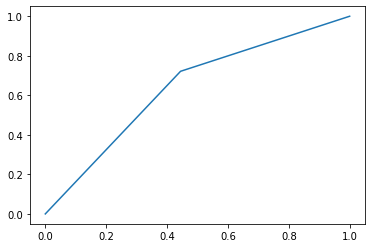

In [149]:
# sklearn에서 ROC 패키지 활용
fpr, tpr, thresholds = roc_curve(test_y,pred_y,pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [150]:
joblib.dump(results, 'logit_lg_model.pkl')

['logit_lg_model.pkl']

# 확률값 계산

In [152]:
logit = joblib.load('logit_lg_model.pkl') 
logit.predict(test_x)

array([-1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
        1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1])

In [153]:
logit.predict_proba(test_x)

array([[0.52995607, 0.47004393],
       [0.42317358, 0.57682642],
       [0.32018714, 0.67981286],
       [0.47493366, 0.52506634],
       [0.51985128, 0.48014872],
       [0.32114157, 0.67885843],
       [0.31646925, 0.68353075],
       [0.38677265, 0.61322735],
       [0.45981575, 0.54018425],
       [0.56718187, 0.43281813],
       [0.51470657, 0.48529343],
       [0.70652395, 0.29347605],
       [0.30305796, 0.69694204],
       [0.68745039, 0.31254961],
       [0.60127623, 0.39872377],
       [0.39802824, 0.60197176],
       [0.53763866, 0.46236134],
       [0.38602545, 0.61397455],
       [0.31733105, 0.68266895],
       [0.52296379, 0.47703621],
       [0.66028216, 0.33971784],
       [0.45655384, 0.54344616],
       [0.4376262 , 0.5623738 ],
       [0.52564336, 0.47435664],
       [0.57392009, 0.42607991],
       [0.43881843, 0.56118157],
       [0.55217123, 0.44782877],
       [0.28251239, 0.71748761],
       [0.40530425, 0.59469575],
       [0.40784284, 0.59215716],
       [0.